# Preparing Dataset for Instruction tuning
In this notebook, I'll prepare a dataset for instruction tuning of Llama-2 7b model. I'll use weights and biases library for versioning of data and model artifacts.

Reference: [Preparing a Dataset for Instruction tuning](https://wandb.ai/capecape/alpaca_ft/reports/How-to-implement-fine-tuning-of-an-LLM-Part-1-Dataset-for-Instruction-Tuning--Vmlldzo1NTcxNzE2)

In [1]:
!pip install wandb transformers

## Prepare the instruction dataset
An Instruction dataset is a list of instructions/outputs pairs that are relevant to your own domain.

In [2]:
!wget https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json

--2024-04-28 09:37:14--  https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43379276 (41M) [text/plain]
Saving to: ‘alpaca_gpt4_data.json.2’

alpaca_gpt4_data.js 100%[===================>]  41.37M   156MB/s    in 0.3s    

2024-04-28 09:37:15 (156 MB/s) - ‘alpaca_gpt4_data.json.2’ saved [43379276/43379276]



In [3]:
import json

dataset_file_name = "/content/alpaca_gpt4_data.json"

with open(dataset_file_name, "r") as f:
  alpaca = json.load(f)

print(alpaca[0:5])

[{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}, {'instruction': 'What are the three primary colors?', 'input': '', 'output': 'The three primary colors are red, blue, and yellow. These colors are called pri

We can see that the dataset contains multiple dictionaries with each dictionary having an instruction, an input, and an output.

But the Llama model which we want to finetune, takes in sequences of tokens. One option is that we concatenate the dataset into text and then finetune the Llama on that.

In [4]:
import wandb

# Log the data to wandb
with wandb.init(project="alpaca_ft"):
  at = wandb.Artifact(
        name="alpaca_gpt4",
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
  at.add_file(dataset_file_name)
  wandb.log_artifact(at)

  # log as table - wandb table is used to visualize the artifacts
  table = wandb.Table(columns=list(alpaca[0].keys()))
  for row in alpaca:
    table.add_data(*row.values())
  wandb.log({"alpaca_gpt4_table": table})

wandb: Currently logged in as: tayyibgondal2003 (nust-isb). Use `wandb login --relogin` to force relogin


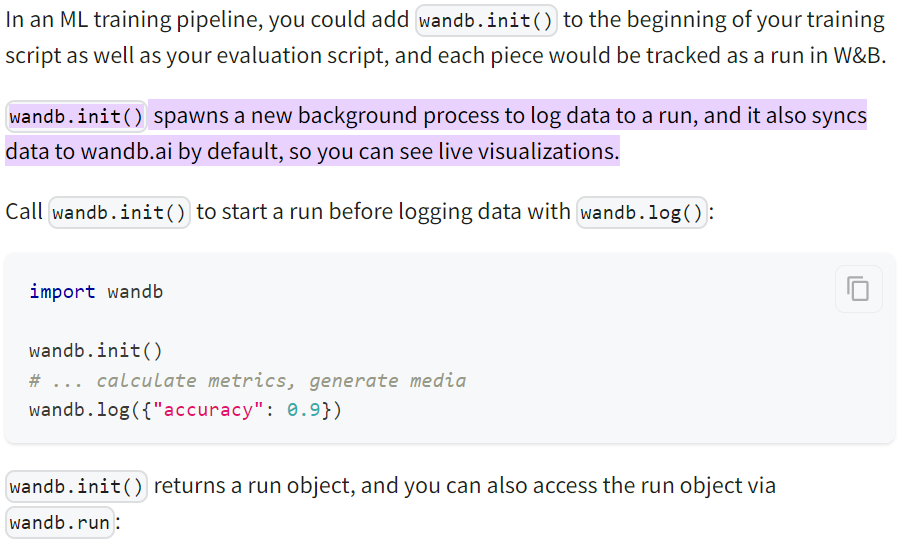

Use W&B Artifacts to track and version any serialized data as the inputs and outputs of your W&B Runs. For example, a model training run might take in a dataset as input and trained model as output. In addition to logging hyper-parameters and metadata to a run, you can use an artifact to log the dataset used to train the model as input and the resulting model checkpoints as outputs. You will always be able answer the question “what version of my dataset was this model trained on”.

## Train eval split

In [5]:
import random

random.shuffle(alpaca)

In [6]:
train_dataset = alpaca[:-1000]
eval_dataset = alpaca[-1000:]

In [7]:
import pandas as pd

train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

train_df.head()

,instruction,input,output
0,Find an example of a business that has success...,,One example of a business that has used creati...
1,Perform an element search on the given array,"[5, 9, 20, 19, 11, 67, 33]","Sure, on which element would you like me to pe..."
2,Calculate the kinetic energy of a moving object,"Object mass: 10kg, Object velocity: 20 m/s",The kinetic energy of a moving object is given...
3,Describe the possible consequences of someone ...,,Living in an overcrowded city can have numerou...
4,Compose a song chorus,,"(Upbeat Tempo)\nIn the light of the day, we're..."


When orient='records' is used:

- Each row of the DataFrame is converted into a JSON object.
- The keys of the JSON objects are the column names.
- The values of the JSON objects are the corresponding values in each row.

In [8]:
train_table = wandb.Table(dataframe=train_df)
eval_table  = wandb.Table(dataframe=eval_df)

train_df.to_json("alpaca_gpt4_train.jsonl", orient='records', lines=True)
eval_df.to_json("alpaca_gpt4_eval.jsonl", orient='records', lines=True)

with wandb.init(project="alpaca_ft", job_type="split_data"):
    at = wandb.Artifact(
        name="alpaca_gpt4_splitted",
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
    at.add_file("alpaca_gpt4_train.jsonl")
    at.add_file("alpaca_gpt4_eval.jsonl")
    wandb.log_artifact(at)

    # We logged the datasets as tables as well so we can inspect it on the workspace.
    wandb.log({"train_dataset":train_table, "eval_dataset":eval_table})

## Making the datasets ingestible for the LLama

In [9]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Response:\n").format_map(row)


def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n").format_map(row)

def create_prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)


In [10]:
# Load the dataset artifacts which you saved to wand (train and eval)
import json
from wandb import Api

api = Api()
artifact = api.artifact('nust-isb/alpaca_ft/alpaca_gpt4_splitted:v0', type='dataset')
artifact_dir = artifact.download()

def load_jsonl(file_path):
  with open(file_path, "r") as f:
    data = [] # List of dictionaries
    for line in f:
      data.append(json.loads(line))
    return data

train_dataset = load_jsonl(f"{artifact_dir}/alpaca_gpt4_train.jsonl")
eval_dataset = load_jsonl(f"{artifact_dir}/alpaca_gpt4_eval.jsonl")

wandb:   2 of 2 files downloaded.  


In [11]:
train_prompts = [create_prompt(row) for row in train_dataset]
eval_prompts = [create_prompt(row) for row in eval_dataset]

In [12]:
def pad_eos(ds):
    EOS_TOKEN = "</s>"
    return [f"{row['output']}{EOS_TOKEN}" for row in ds]

In [13]:
train_outputs = pad_eos(train_dataset)
eval_outputs = pad_eos(eval_dataset)
train_outputs[0]

"1. What inspired you to pursue a career in customer service?\n2. Can you tell me about a time you went above and beyond for a customer? \n3. How do you handle difficult or upset customers? \n4. In your opinion, what is the most important aspect of customer service? \n5. What steps do you take to ensure a customer leaves a conversation satisfied? \n6. Describe how you have collaborated with other team members to improve customer service.  \n7. How do you handle a situation when you do not know the answer to a customer's question? \n8. Can you tell me about a specific scenario in which you handled a customer complaint effectively?\n9. How do you ensure that you provide a professional and friendly demeanor when interacting with customers, both in person and over the phone? \n10. How do you stay up-to-date with the company’s products and services to better assist customers?</s>"

Let's combine the prompts and the outputs and store them in a final variable named 'examples'.

In [14]:
train_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(train_prompts, train_outputs)]
eval_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(eval_prompts, eval_outputs)]

In [15]:
print(train_dataset[0]['example'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a list of interview questions to evaluate a potential hire for a customer service representative position.

### Response:
1. What inspired you to pursue a career in customer service?
2. Can you tell me about a time you went above and beyond for a customer? 
3. How do you handle difficult or upset customers? 
4. In your opinion, what is the most important aspect of customer service? 
5. What steps do you take to ensure a customer leaves a conversation satisfied? 
6. Describe how you have collaborated with other team members to improve customer service.  
7. How do you handle a situation when you do not know the answer to a customer's question? 
8. Can you tell me about a specific scenario in which you handled a customer complaint effectively?
9. How do you ensure that you provide a professional and friendly demeanor when interacting with customers, both in p

## Tokenizer

In [16]:
pip install --upgrade huggingface_hub

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [25]:
!echo 'https://download.llamameta.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoibzRienJqdWs2c29ibzBjeGl5djVyOWc4IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZG93bmxvYWQubGxhbWFtZXRhLm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDM4Mzc4OX19fV19&Signature=X40kmHdxSW3Y79%7Eem-o265O6GGAJKMVxlYBqxHESaOoXgf0Vq1fTJppaF3ueTKJeUqspWfhNC3g2j29HoG%7E2XLD4AzPPv75z8Z-dGW-WygdAlXuIekyOh9GRfchocS7TOPZI-tVNIjf769MNxptDfUpXc6oCYQ-z0or-brofOf3QNqYwxZxlMt53bn7KiKgVw7nxcazMqUgtZXAO1A3EINtF%7Ez61Roby1Zwi3juFASTjslVzZC4ID09rV2boKZ76nFljcjmreEa-1siGlVvyLpbzbp3e5fNCXglXkwm2TQE3XKtAmv8zWcOHwYSATCcf6ry%7EBq-qB64B5D93pcc0rQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=405157518994451' > url.txt

In [27]:
!bash download.sh < url.txt

In [31]:
model_id = 'meta-llama/Llama-2-7b-hf'
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

## Packing
We will pack multiple short examples into a longer chunk, so we can train more efficiently!

The main idea here is that the instruction/output samples are short, so let's concatenate a bunch of them together separated by the EOS token. We can also pre-tokenize and pre-pack the dataset and make everything faster! If we define a max_seq_len = 1024 the code to pack would look something like this:

In [ ]:
max_sequence_len = 1024

def pack(dataset, max_seq_len=max_sequence_len):
    list_of_token_ids_for_each_example = tokenizer([record["example"] for record in dataset])["input_ids"]

    all_token_ids = []
    for tokenized_input in list_of_token_ids_for_each_example:
        all_token_ids.extend(tokenized_input) # + [tokenizer.eos_token_id])

    print(f"Total number of tokens: {len(all_token_ids)}")
    packed_ds = []
    for i in range(0, len(all_token_ids), max_seq_len+1):
        input_ids = all_token_ids[i : i + max_seq_len+1]
        if len(input_ids) == (max_seq_len+1):
            packed_ds.append({"input_ids": input_ids[:-1], "labels": input_ids[1:]})  # this shift is not needed if using the model.loss
    return packed_ds

In [ ]:
train_ds_packed = pack(train_dataset)
eval_ds_packed = pack(eval_dataset)
len(train_ds_packed)

## Storing our final preprocessed data as artifact in wandb
Now that we have packed our datasets we can save them securely to train a model!

In [ ]:
import json
def save_jsonl(data, filename):
    with open(filename, 'w') as file:
        for entry in data:
            json.dump(entry, file)
            file.write('\n')


# dump everything to jsonl files
save_jsonl(train_ds_packed, "train_packed_alpaca.jsonl")
save_jsonl(eval_ds_packed, "eval_packed_alpaca.jsonl")


# Create a W&B artifact
packed_at = wandb.Artifact(
    name="packed_alpaca",
    type="dataset",
    description="Alpaca dataset packed in sequences",
    metadata={"max_seq_len":1024, "model_id":model_id})


packed_at.add_file("train_packed_alpaca.jsonl")
packed_at.add_file("eval_packed_alpaca.jsonl")


# log the artifact to the project, we can give this run a job_type like `preprocess`
with wandb.init(project="alpaca_ft", job_type="preprocess"):
    wandb.log_artifact(packed_at)